In [4]:
!pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=4b7d30d06da9927b1534ef3e239a3bebb00dc10a046ec430e6b4d374d1551865
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


# Importing Necessary Packages

In [5]:
%load_ext memory_profiler

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, losses, metrics, callbacks, datasets
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
seed=42
tf.random.set_seed(seed)

# Preprocessing of the Dataset

In [7]:
(X_train,y_train),(X_test,y_test)=datasets.fashion_mnist.load_data()
class_names=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt',
            'Sneaker','Bag','Ankle Boot']
# Normalizing
X_train, X_test= X_train/255.0, X_test/255.0

# Checking shape of the data
print(f"X-train shape: {X_train.shape}")
print(f"y-train shape: {y_train.shape}")
print(f"X-test shape: {X_test.shape}")
print(f"y-test shape: {y_test.shape}")

4431872/4422102 [==============================] - 0s 0us/step
X-train shape: (60000, 28, 28)
y-train shape: (60000,)
X-test shape: (10000, 28, 28)
y-test shape: (10000,)


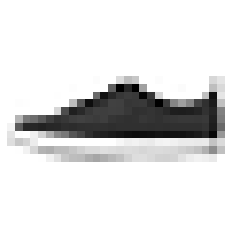

It is a  Sneaker


In [8]:
#plotting a sample 
index=20000
plt.imshow(X_train[index],cmap='binary')
plt.axis('off')
plt.show()
print('It is a ',class_names[y_train[index]])

In [9]:
#converting the images to a column vector of dimension 28*28 = 784
X_train = X_train.reshape(X_train.shape[0],-1)
y_train = y_train.reshape(y_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
y_test = y_test.reshape(y_test.shape[0],-1)

# Logistic Regression

In [10]:
%%time
%%memit
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train, y_train)

peak memory: 1070.68 MiB, increment: 1.10 MiB
CPU times: user 2min 13s, sys: 12.9 s, total: 2min 25s
Wall time: 1min 29s


In [11]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.8416

# Using Clustering For Semi-Supervised Learning

In [12]:
%%time
%%memit
k=[200,300,500]
pipeline=np.empty(len(k),dtype=object)
for i in range(len(k)):
    pipeline[i] = Pipeline([("kmeans", KMeans(init='k-means++',n_clusters=k[i], random_state=seed)),
                         ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs",
                                                        max_iter=500, random_state=seed))])
    pipeline[i].fit(X_train, y_train.ravel())
    print('Cluster= {}, Accuracy= {}'.format(k[i],
            pipeline[i].score(X_test,y_test)))

Cluster= 200, Accuracy= 0.8366
Cluster= 300, Accuracy= 0.8425
Cluster= 500, Accuracy= 0.8442
peak memory: 1858.42 MiB, increment: 767.96 MiB
CPU times: user 1h 23min 24s, sys: 6min 18s, total: 1h 29min 42s
Wall time: 47min 32s


# Checking for Optimum Number of Clusters

In [16]:
from sklearn.model_selection import GridSearchCV

In [18]:
param_grid = dict(kmeans__n_clusters=range(1000, 3000, 1000))
grid_clf = GridSearchCV(pipeline, param_grid, cv=2, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] END ............................kmeans__n_clusters=1000; total time=18.2min
[CV] END ............................kmeans__n_clusters=1000; total time=18.3min
[CV] END ............................kmeans__n_clusters=2000; total time=36.6min
[CV] END ............................kmeans__n_clusters=2000; total time=36.4min


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=2000,
                                               random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=500,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(1000, 3000, 1000)},
             verbose=2)

In [19]:
grid_clf.best_params_

{'kmeans__n_clusters': 2000}

In [20]:
grid_clf.score(X_test, y_test)

0.8508

In [13]:
%%time
%%memit
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=2000, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500, random_state=42)),
])
pipeline.fit(X_train, y_train)

peak memory: 2478.46 MiB, increment: 620.04 MiB
CPU times: user 2h 16min 19s, sys: 4min 45s, total: 2h 21min 5s
Wall time: 1h 13min 25s


In [14]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.8508

In [15]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.058080808080807955

# Random Labelled Instances

In [21]:
n_labeled = [1000, 1500, 2000]

In [22]:
%%time
%%memit
log_reg2=np.empty(len(n_labeled),dtype=object)
for i in range(len(n_labeled)):
    log_reg2[i] = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=seed)
    log_reg2[i].fit(X_train[:n_labeled[i]], y_train[:n_labeled[i]].ravel())
    print('Labelled Instance= {}, Accuracy= {}'.format(n_labeled[i],
            log_reg2[i].score(X_test, y_test.ravel())))

Labelled Instance= 1000, Accuracy= 0.7877
Labelled Instance= 1500, Accuracy= 0.8009
Labelled Instance= 2000, Accuracy= 0.8041
peak memory: 3290.54 MiB, increment: 0.50 MiB
CPU times: user 8.09 s, sys: 2.47 s, total: 10.6 s
Wall time: 5.81 s


In [23]:
k = 200

In [24]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_fashions_dist = kmeans.fit_transform(X_train)
representative_fashion_idx = np.argmin(X_fashions_dist, axis=0)
X_representative_fashions = X_train[representative_fashion_idx]

In [25]:
# To plot pretty figures
%matplotlib inline
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure representative_images_diagram


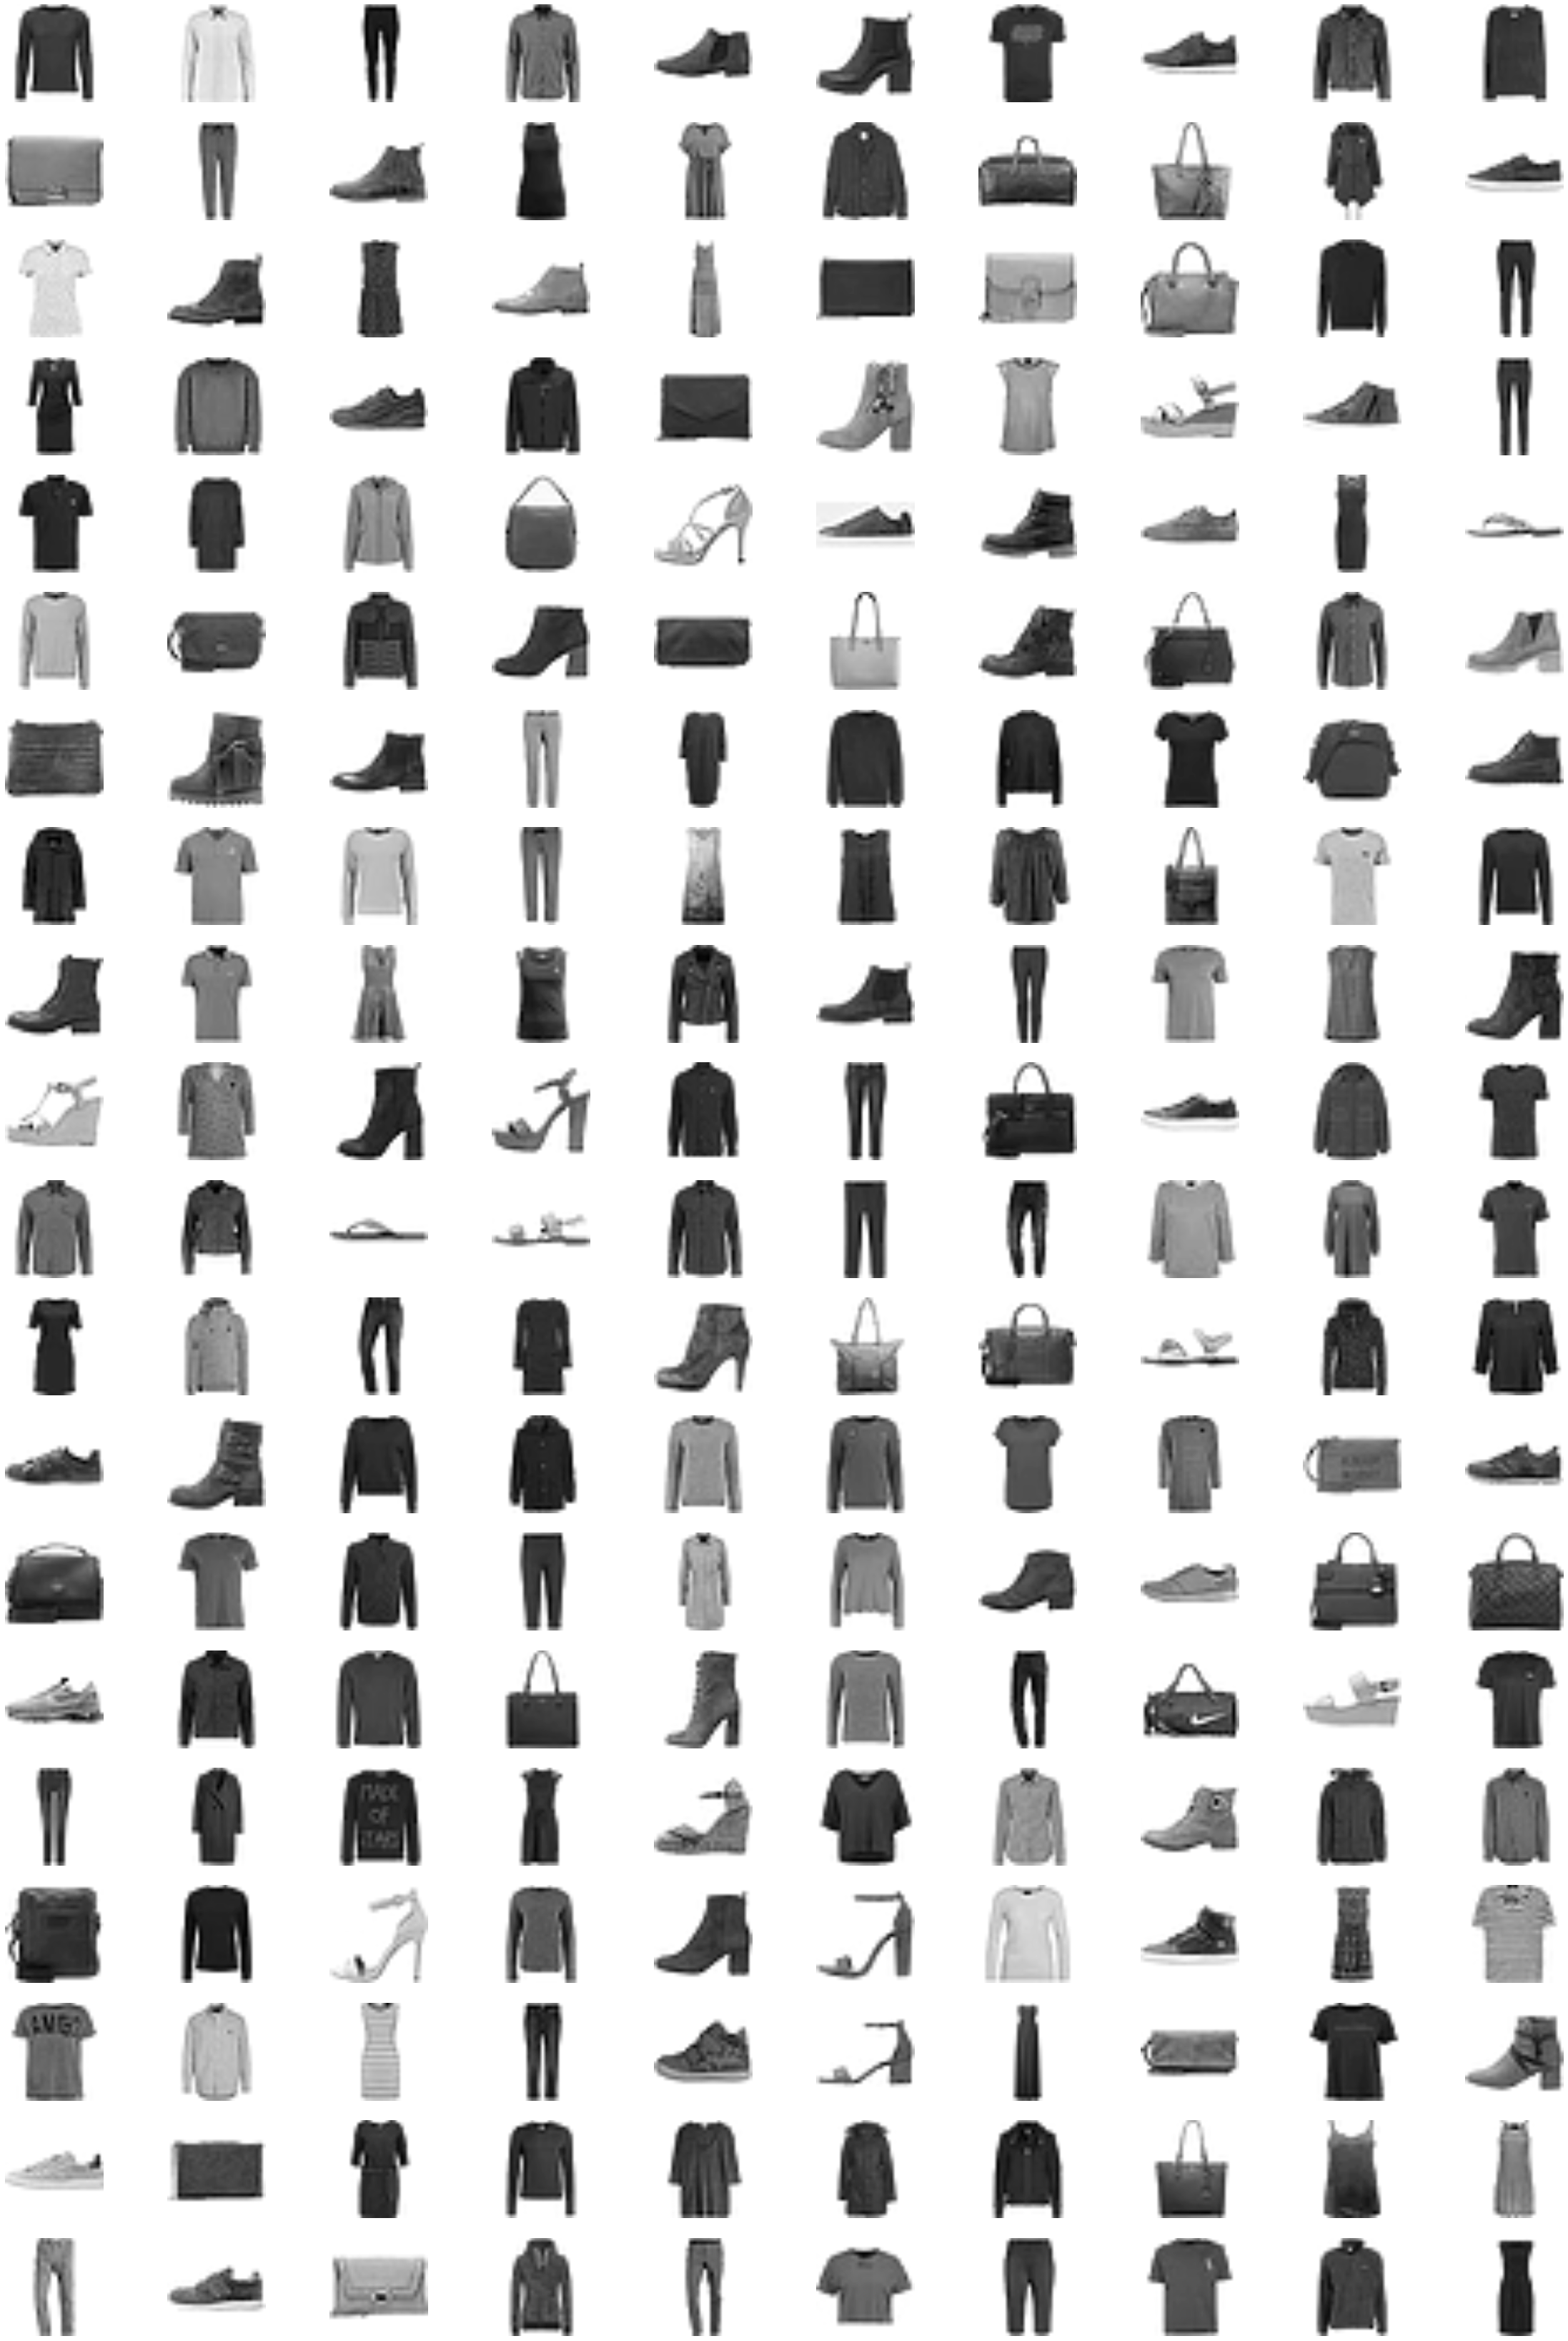

In [27]:
plt.figure(figsize=(40, 60))
for index, X_representative_fashion in enumerate(X_representative_fashions):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_fashion.reshape(28, 28), cmap="binary", interpolation="bilinear")
    plt.axis('off')
    
save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [28]:
y_train[representative_fashion_idx]

array([[2],
       [6],
       [1],
       [6],
       [9],
       [9],
       [0],
       [7],
       [4],
       [2],
       [8],
       [1],
       [9],
       [0],
       [3],
       [4],
       [8],
       [8],
       [4],
       [7],
       [0],
       [9],
       [3],
       [9],
       [3],
       [8],
       [8],
       [8],
       [2],
       [1],
       [3],
       [2],
       [7],
       [4],
       [8],
       [9],
       [0],
       [5],
       [7],
       [1],
       [0],
       [3],
       [4],
       [8],
       [5],
       [7],
       [9],
       [7],
       [3],
       [5],
       [2],
       [8],
       [4],
       [9],
       [8],
       [8],
       [9],
       [8],
       [6],
       [9],
       [8],
       [9],
       [9],
       [1],
       [3],
       [2],
       [2],
       [0],
       [8],
       [9],
       [4],
       [0],
       [2],
       [1],
       [3],
       [6],
       [6],
       [8],
       [0],
       [2],
       [9],
       [0],
       [3],
    

In [29]:
y_representative_fashions = np.array(y_train[representative_fashion_idx])

In [30]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500, random_state=42)
log_reg.fit(X_representative_fashions, y_representative_fashions)
log_reg.score(X_test, y_test)

0.7673

In [31]:
k = 2000

In [33]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_fashions_dist = kmeans.fit_transform(X_train)
representative_fashion_idx = np.argmin(X_fashions_dist, axis=0)
X_representative_fashions = X_train[representative_fashion_idx]

Saving figure representative_images_diagram


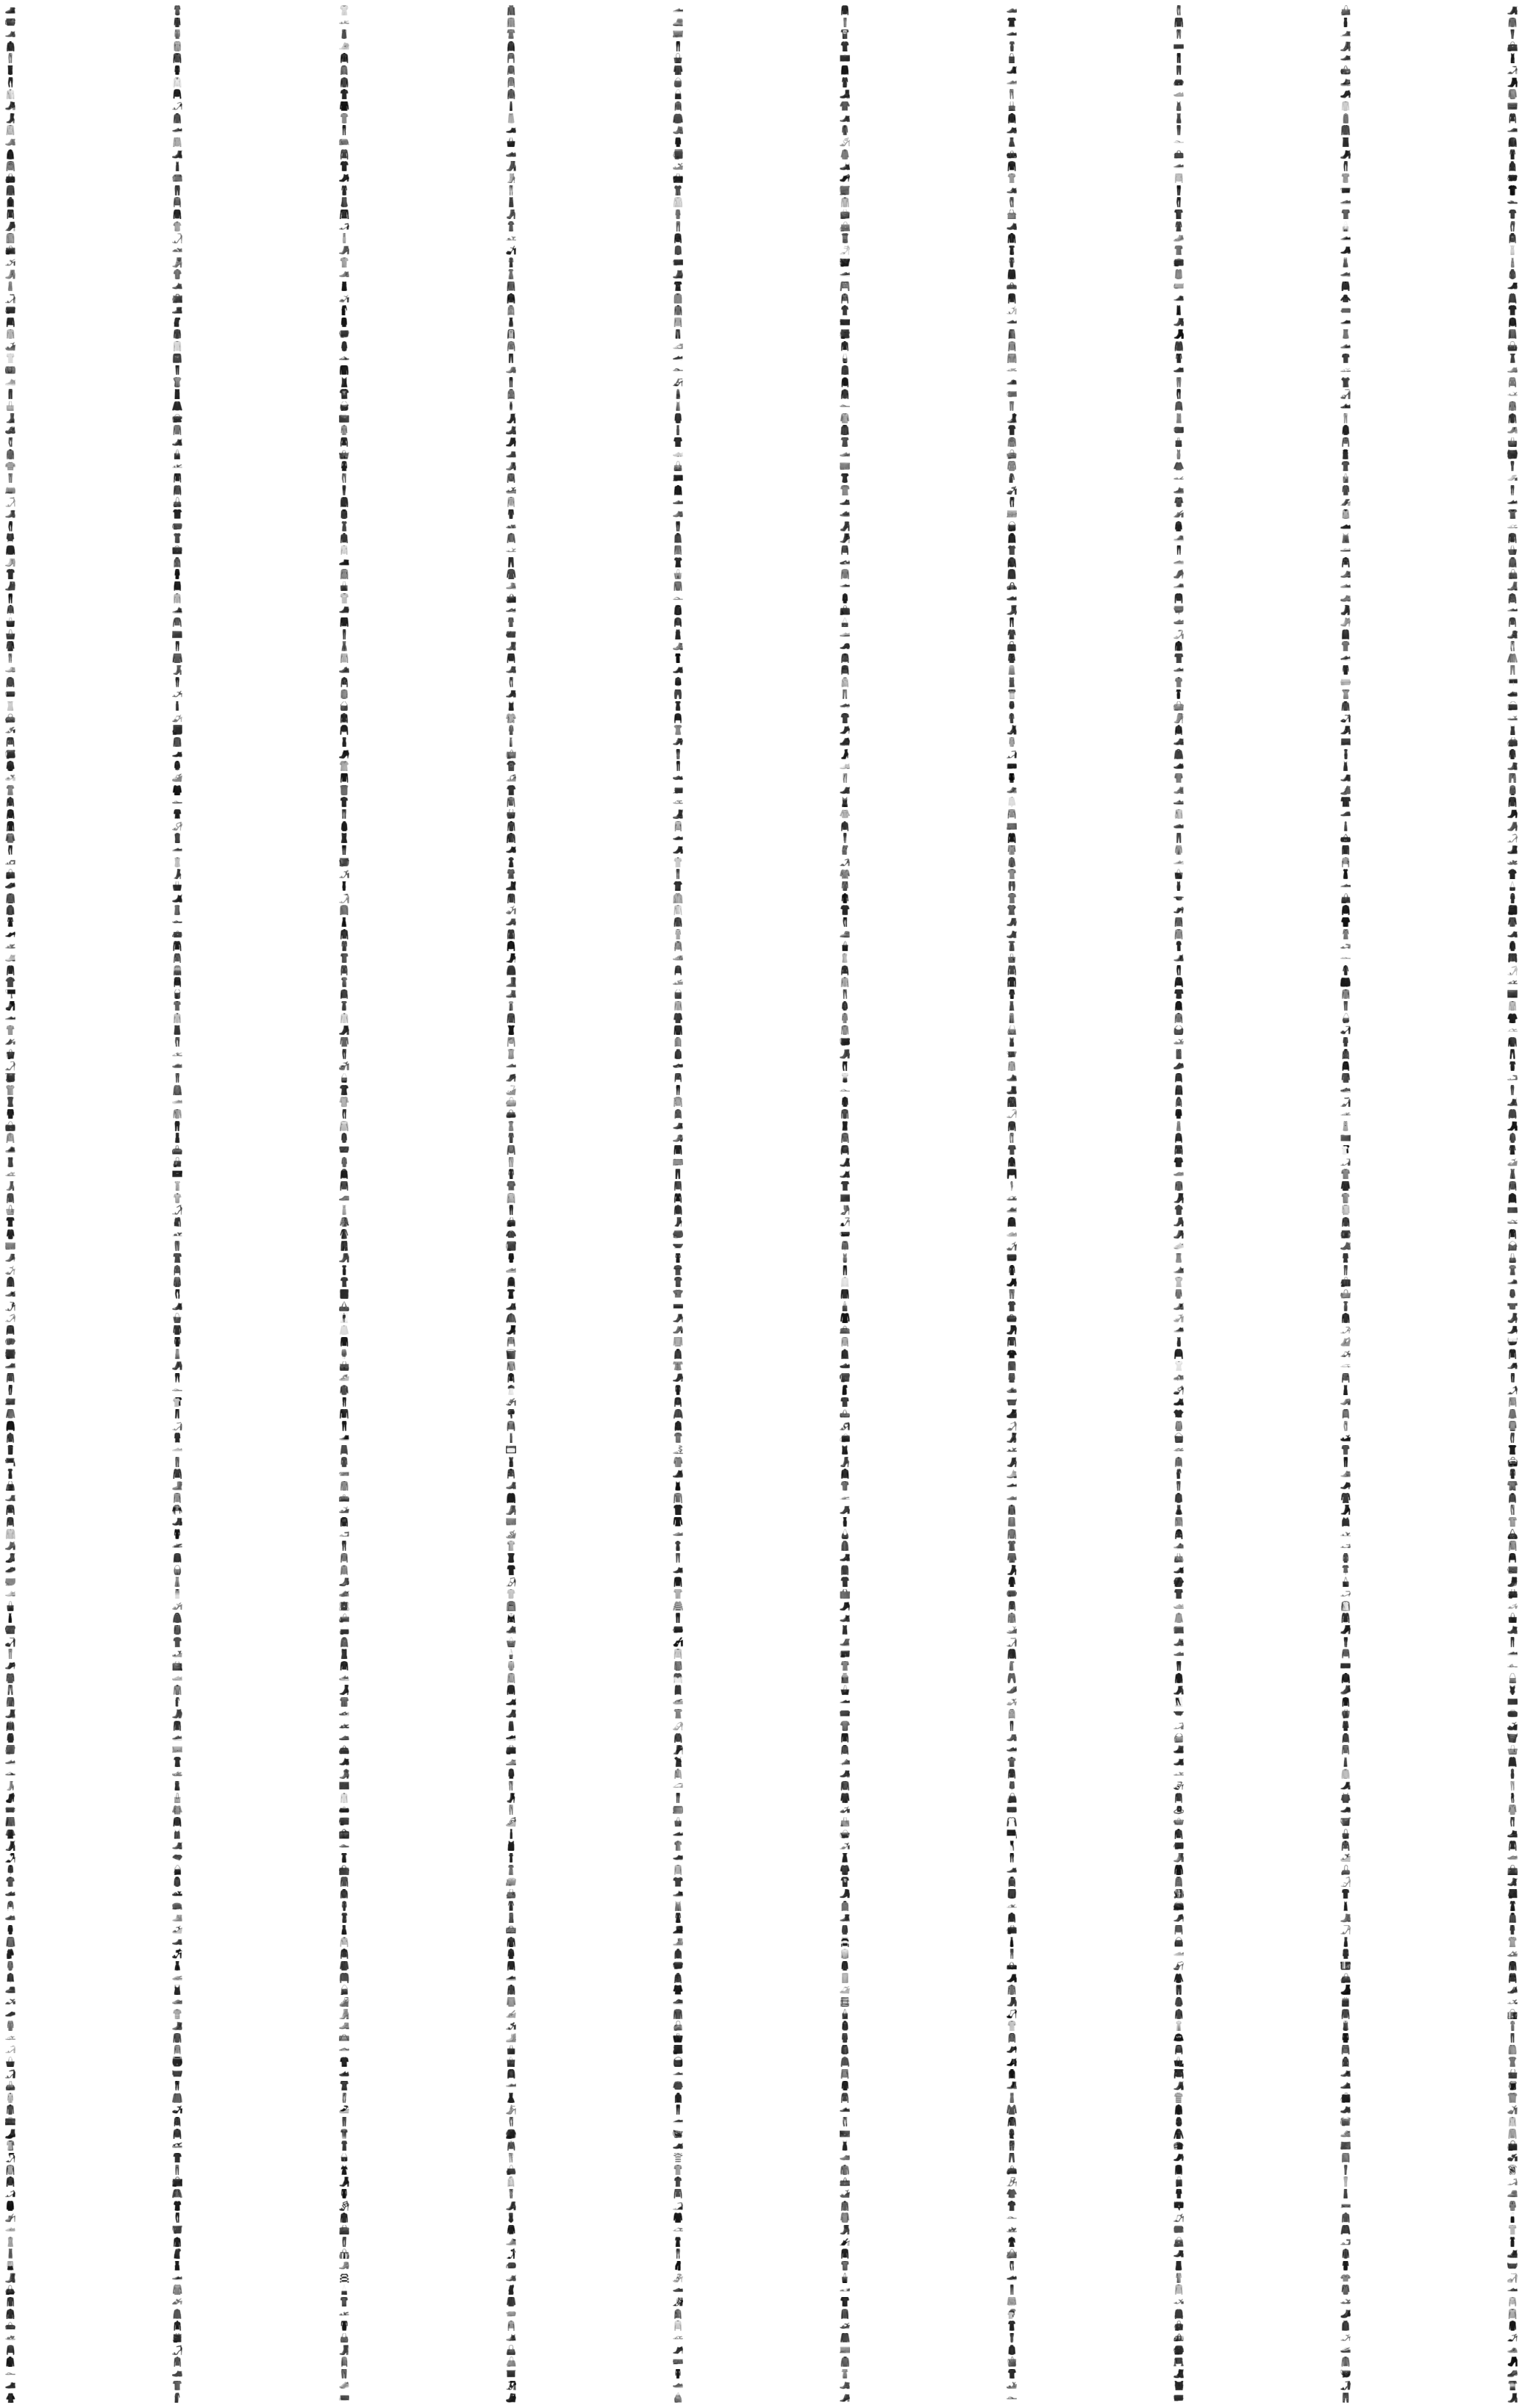

In [34]:
plt.figure(figsize=(40, 60))
for index, X_representative_fashion in enumerate(X_representative_fashions):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_fashion.reshape(28, 28), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [35]:
y_train[representative_fashion_idx]

array([[9],
       [0],
       [0],
       ...,
       [8],
       [1],
       [9]], dtype=uint8)

In [36]:
y_representative_fashions = np.array(y_train[representative_fashion_idx])

In [37]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500, random_state=42)
log_reg.fit(X_representative_fashions, y_representative_fashions)
log_reg.score(X_test, y_test)

0.814

# Propgating Same Labels to each Data Points in a Cluster

In [38]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_fashions[i]

In [39]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=42)

In [40]:
log_reg.score(X_test, y_test)

0.8121

# Partially Propgating Labels to each Data Point closer to the Centroids

In [41]:
def partial_prop(percentile_closest):
    X_cluster_dist = X_fashions_dist[np.arange(len(X_train)), kmeans.labels_]
    for i in range(k):
        in_cluster = (kmeans.labels_ == i)
        cluster_dist = X_cluster_dist[in_cluster]
        cutoff_distance = np.percentile(cluster_dist, percentile_closest)
        above_cutoff = (X_cluster_dist > cutoff_distance)
        X_cluster_dist[in_cluster & above_cutoff] = -1
    partially_propagated = (X_cluster_dist != -1)
    X_train_partially_propagated = X_train[partially_propagated]
    y_train_partially_propagated = y_train_propagated[partially_propagated]
    log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500, random_state=42)
    log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
    return(log_reg.score(X_test, y_test))

In [42]:
%%time
%%memit

for i in [25,50,75]:
    print('Percentile= ',i)
    print(partial_prop(percentile_closest=i))

Percentile=  25
0.8042
Percentile=  50
0.809
Percentile=  75
0.8124
peak memory: 3907.97 MiB, increment: 179.22 MiB
CPU times: user 13min 29s, sys: 1min, total: 14min 29s
Wall time: 7min 33s


In [52]:
percentile_closest = 85

X_cluster_dist = X_fashions_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [53]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [54]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=42)

In [55]:
log_reg.score(X_test, y_test)

0.8129

In [43]:
percentile_closest = 80

X_cluster_dist = X_fashions_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [44]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [45]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=500, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=500, multi_class='ovr', random_state=42)

In [46]:
log_reg.score(X_test, y_test)

0.8136

In [47]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.10016732851104256